In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import time 
from keras import callbacks


In [2]:
dataset_dir_EXT = 'CNR-EXT-150x150/'
split_test_EXT = 'CNR-EXT-150x150/LABELS/test.txt'
split_train_EXT = 'CNR-EXT-150x150/LABELS/train.txt'
split_val_EXT = 'CNR-EXT-150x150/LABELS/val.txt'

# Define the image size and batch size
image_size = (224, 224)  
batch_size = 64

# Create a function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

# Training model with data augmentation
def load_and_augment_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.random_flip_left_right(image)  # to simulate varying car orientations facing the camera 
    image = tf.image.random_brightness(image, max_delta=0.4) # to simulate parking lot in different daytimes and lighting conditions
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # to simulate parking lot in different daytimes and lighting conditions
    
    image = tf.image.resize(image, image_size)
    image = tf.image.convert_image_dtype(image, tf.float32)    
    return image, label


def create_dataset(split_file, dataset_dir, load_images):    
    image_paths = []
    labels = []

    with open(split_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                image_path = os.path.join(dataset_dir, parts[0])
                label = int(parts[1])
                image_paths.append(image_path)
                labels.append(label)

    labels = np.array(labels, dtype=np.int32)
    labels = tf.one_hot(labels, 2)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_images)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset


def show_image_from_dataset(datasets):
    for dataset in datasets:
        for images, labels in train_dataset.take(1): 
            print("Image shape:", images.shape)
            plt.figure(figsize=(8, 3))
            for i in range(2):  
                plt.subplot(1, 2, i + 1)
                im = images[i] / 255.0 
                plt.imshow(im)
                plt.title("Label: {}".format(labels[i].numpy()))
            plt.show()


def test_quantized_model(model_path, test_dataset):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    
    # Initialize variables for accuracy calculation
    correct_predictions = 0
    total_samples = 0
    
    for i, (batch_input_data, batch_true_labels) in enumerate(test_dataset, 1):
        if i % 50 == 0:
            acc = correct_predictions / total_samples
            print(f"Batch {i} accuracy: {acc:.4f}")
        # Iterate through each sample in the batch
        for i in range(batch_input_data.shape[0]):        
            input_data = batch_input_data[i:i + 1]
    
            # Set input tensor
            interpreter.set_tensor(input_index, input_data.numpy())
    
            # Run inference
            interpreter.invoke()
    
            # Get output tensor
            output_data = interpreter.get_tensor(output_index)  
            true_label = batch_true_labels[i].numpy()
            predicted_label = np.argmax(output_data, axis=1)
            true_label = np.argmax(true_label)
            if predicted_label == true_label:   
                correct_predictions += 1
            total_samples += 1
            
        
        
    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    return accuracy

In [3]:
avg_train_times = []
inference_times = []
test_accuracies = []

In [4]:
class epoch_counter_callback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epochs = 0
    def on_epoch_end(self,epoch,logs = {}):
        self.epochs += 1
    def on_train_end(self,logs = {}):
        print(f"Trained for {self.epochs} epochs")

## **mAlexNet (baseline)**

Train dataset size: 1477 batches
Val dataset size: 292 batches
Test dataset size: 498 batches
Image shape: (64, 224, 224, 3)


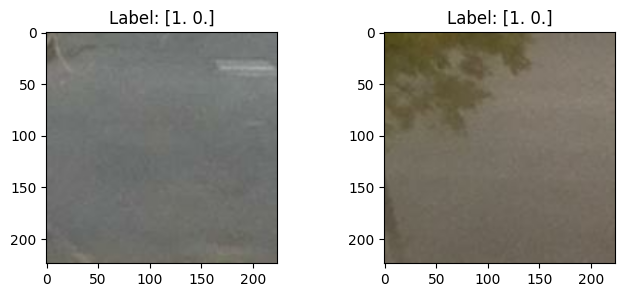

Image shape: (64, 224, 224, 3)


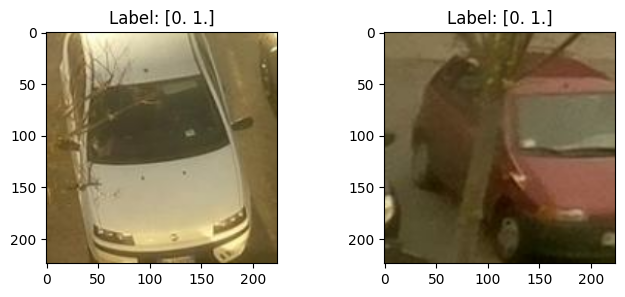

Image shape: (64, 224, 224, 3)


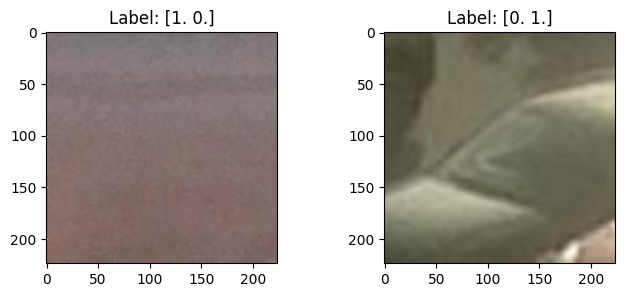

In [5]:
image_size = (224, 224) 
train_dataset = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_preprocess_image)
val_dataset = create_dataset(split_val_EXT, dataset_dir_EXT, load_and_preprocess_image)
test_dataset = create_dataset(split_test_EXT, dataset_dir_EXT, load_and_preprocess_image)

train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Train dataset size: {train_size} batches")
print(f"Val dataset size: {val_size} batches")
print(f"Test dataset size: {test_size} batches")

show_image_from_dataset([train_dataset, val_dataset, test_dataset])

In [6]:
num_classes = 2  
input_shape = (224, 224, 3)  

# mAlexNet (baseline)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=11, strides=4, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv2D(20, kernel_size=5, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv2D(30, kernel_size=3, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 16)        5824      
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 20)        8020      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 30)          5430      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 30)         

In [7]:
epochs = 50

earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

training_start_malexnet = time.time()
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)
training_end_malexnet = time.time()

# Save the trained model
model.save('models/malexnet_standard.keras')

Epoch 1/50




1477/1477 [==============================] - 54s 36ms/step - loss: 0.1546 - accuracy: 0.9535 - val_loss: 0.1189 - val_accuracy: 0.9642
Epoch 2/50
1477/1477 [==============================] - 53s 36ms/step - loss: 0.0932 - accuracy: 0.9696 - val_loss: 0.0835 - val_accuracy: 0.9763
Epoch 3/50
1477/1477 [==============================] - 53s 36ms/step - loss: 0.0842 - accuracy: 0.9720 - val_loss: 0.1017 - val_accuracy: 0.9702
Epoch 4/50
1477/1477 [==============================] - 53s 36ms/step - loss: 0.1701 - accuracy: 0.9379 - val_loss: 0.1787 - val_accuracy: 0.9354
Epoch 5/50
1477/1477 [==============================] - 53s 36ms/step - loss: 0.1287 - accuracy: 0.9534 - val_loss: 0.0993 - val_accuracy: 0.9665
Trained for 5 epochs


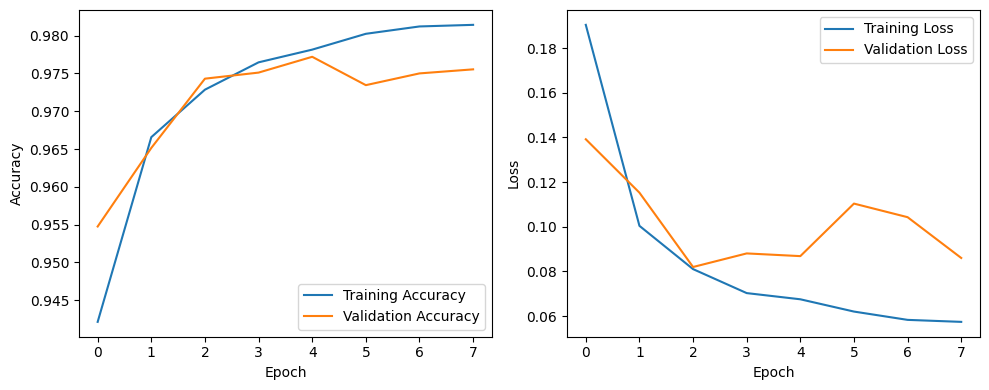

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [31]:
inference_start_malexnet = time.time()
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_malexnet = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

test_accuracies.append(results[1])

498/498 [==============================] - 10s 20ms/step - loss: 0.0752 - accuracy: 0.9754
Testing on CNR_EXT dataset: test loss: 0.07517776638269424, test acc: 0.9753966927528381


In [32]:
train_time = (training_end_malexnet - training_start_malexnet) / epoch_counter.epochs
print("mAlexNet (Baseline): average training time per epoch =", train_time)
avg_train_times.append(train_time)

inference_time = inference_end_malexnet - inference_start_malexnet
print("mAlexNet (Baseline): inference time for the whole test dataset =", inference_time)
inference_times.append(inference_time)

mAlexNet (Baseline): average training time per epoch = 52.09747704863548
mAlexNet (Baseline): inference time for the whole test dataset = 9.961403846740723


## **mAlexNet + Quantization**

In [33]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/malexnet_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

acc = test_quantized_model('models/malexnet_quantized.tflite', test_dataset)
print("mAlexNet + Quantization: test accuracy =", acc)
test_accuracies.append(acc)

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp_gta83dt\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp_gta83dt\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.9745
Batch 100 accuracy: 0.9768
Batch 150 accuracy: 0.9749
Batch 200 accuracy: 0.9751
Batch 250 accuracy: 0.9756
Batch 300 accuracy: 0.9750
Batch 350 accuracy: 0.9748
Batch 400 accuracy: 0.9749
Batch 450 accuracy: 0.9754
mAlexNet + Quantization: test accuracy = 0.9754595443833465


## **mAlexNet + Data augmentation**

Image shape: (64, 224, 224, 3)


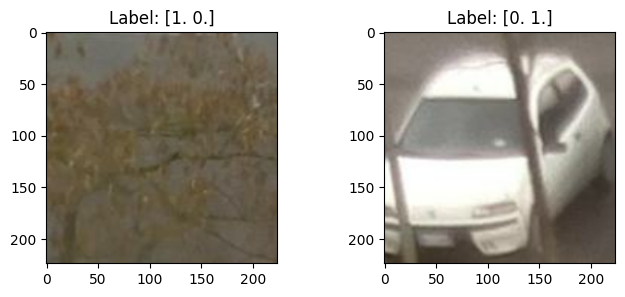

In [34]:
image_size = (224, 224) 
train_dataset_augmented = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_augment_image)
train_dataset_augmented = train_dataset_augmented
show_image_from_dataset([train_dataset_augmented])

In [35]:
num_classes = 2  
input_shape = (224, 224, 3)  

# mAlexNet (baseline)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=11, strides=4, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv2D(20, kernel_size=5, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv2D(30, kernel_size=3, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

In [37]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

# Train the model
history = model.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)

# Save the trained model
model.save('models/malexnet_augmented.keras')


Epoch 1/50
1477/1477 [==============================] - 220s 146ms/step - loss: 0.2620 - accuracy: 0.9160 - val_loss: 0.1279 - val_accuracy: 0.9538
Epoch 2/50
1477/1477 [==============================] - 202s 135ms/step - loss: 0.1480 - accuracy: 0.9468 - val_loss: 0.1116 - val_accuracy: 0.9641
Epoch 3/50
1477/1477 [==============================] - 203s 136ms/step - loss: 0.1358 - accuracy: 0.9516 - val_loss: 0.1082 - val_accuracy: 0.9666
Epoch 4/50
1477/1477 [==============================] - 235s 157ms/step - loss: 0.1263 - accuracy: 0.9551 - val_loss: 0.1013 - val_accuracy: 0.9640
Epoch 5/50
1477/1477 [==============================] - 210s 140ms/step - loss: 0.1189 - accuracy: 0.9572 - val_loss: 0.2314 - val_accuracy: 0.9077
Epoch 6/50
1477/1477 [==============================] - 201s 134ms/step - loss: 0.1150 - accuracy: 0.9593 - val_loss: 0.0818 - val_accuracy: 0.9731
Epoch 7/50
1477/1477 [==============================] - 200s 134ms/step - loss: 0.1068 - accuracy: 0.9622 - val_

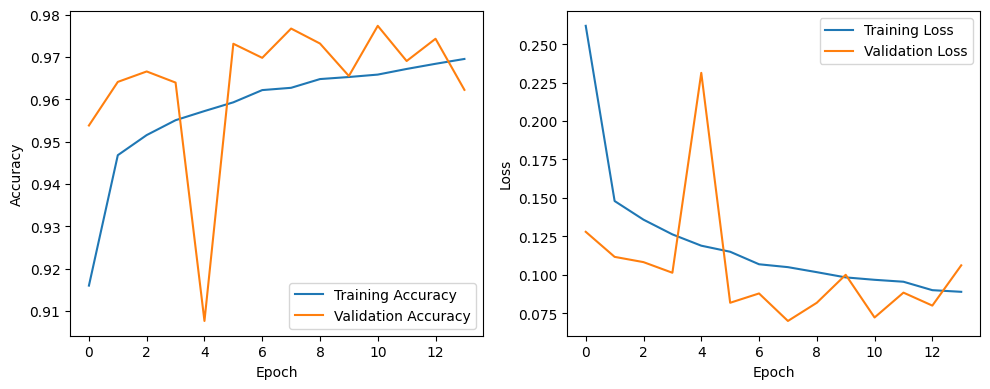

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [39]:
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")
test_accuracies.append(results[1])

498/498 [==============================] - 10s 20ms/step - loss: 0.0613 - accuracy: 0.9798
Testing on CNR_EXT dataset: test loss: 0.0613364540040493, test acc: 0.9797643423080444


## **mAlexNet + Data augmentation+ Quantization**

In [40]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/malexnet_augmented_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

acc = test_quantized_model('models/malexnet_augmented_quantized.tflite', test_dataset)
print("mAlexNet + Data augmentation + Quantization: test accuracy =", acc)
test_accuracies.append(acc)


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpspe16d15\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpspe16d15\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.9777
Batch 100 accuracy: 0.9796
Batch 150 accuracy: 0.9810
Batch 200 accuracy: 0.9803
Batch 250 accuracy: 0.9799
Batch 300 accuracy: 0.9803
Batch 350 accuracy: 0.9800
Batch 400 accuracy: 0.9793
Batch 450 accuracy: 0.9795
mAlexNet + Data augmentation + Quantization: test accuracy = 0.9794815396700707


## **mAlexNet (modified)**

Train dataset size: 1477 batches
Val dataset size: 292 batches
Test dataset size: 498 batches
Image shape: (64, 32, 32, 3)


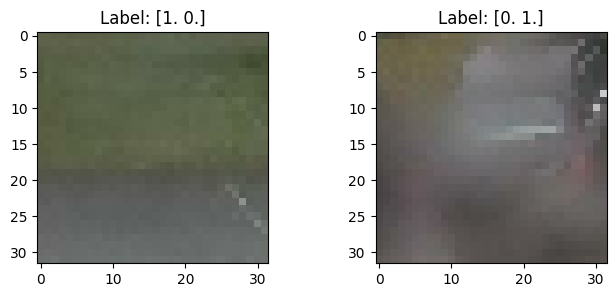

Image shape: (64, 32, 32, 3)


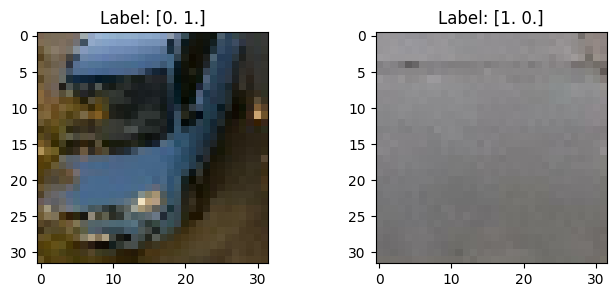

Image shape: (64, 32, 32, 3)


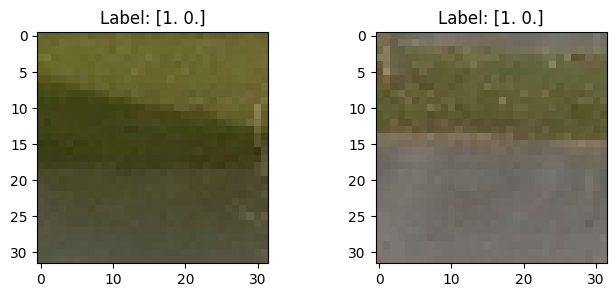

In [41]:
image_size = (32, 32)  

train_dataset = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_preprocess_image)
val_dataset = create_dataset(split_val_EXT, dataset_dir_EXT, load_and_preprocess_image)
test_dataset = create_dataset(split_test_EXT, dataset_dir_EXT, load_and_preprocess_image)

train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Train dataset size: {train_size} batches")
print(f"Val dataset size: {val_size} batches")
print(f"Test dataset size: {test_size} batches")

show_image_from_dataset([train_dataset, val_dataset, test_dataset])


In [42]:
num_classes = 2  
input_shape = (32, 32, 3)  

# mAlexNet (modified)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=4, strides=1, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(20, kernel_size=3, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(30, kernel_size=2, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 29, 29, 16)        784       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 20)        2900      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 6, 6, 20)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 5, 30)          2430      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 2, 2, 30)         

In [43]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

training_start_malexnet_mod = time.time()
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)
training_end_malexnet_mod = time.time()

# Save the trained model
model.save('models/malexnet_modified.keras')

Epoch 1/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.1642 - accuracy: 0.9484 - val_loss: 0.1220 - val_accuracy: 0.9627
Epoch 2/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.0968 - accuracy: 0.9662 - val_loss: 0.1084 - val_accuracy: 0.9671
Epoch 3/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.0811 - accuracy: 0.9719 - val_loss: 0.1080 - val_accuracy: 0.9695
Epoch 4/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.0738 - accuracy: 0.9746 - val_loss: 0.1293 - val_accuracy: 0.9621
Epoch 5/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.0665 - accuracy: 0.9776 - val_loss: 0.1053 - val_accuracy: 0.9720
Epoch 6/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.0610 - accuracy: 0.9799 - val_loss: 0.1418 - val_accuracy: 0.9614
Epoch 7/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.0581 - accuracy: 0.9803 - val_loss: 0.0965 - val_ac

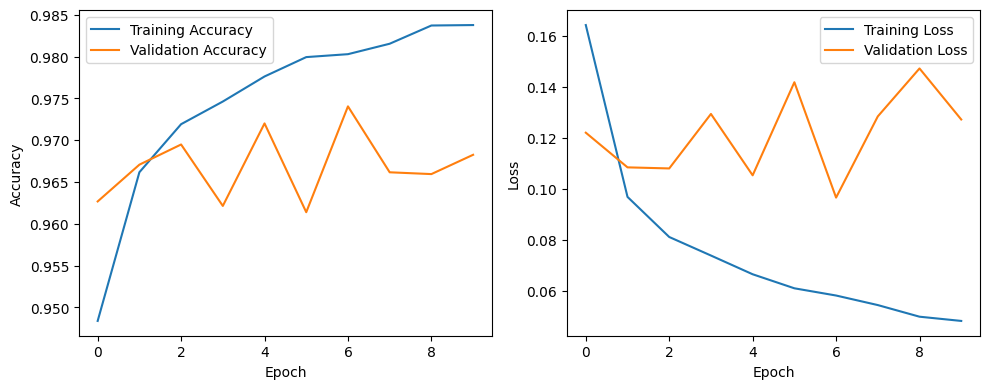

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [45]:
inference_start_malexnet_mod = time.time()
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_malexnet_mod = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

test_accuracies.append(results[1])

498/498 [==============================] - 2s 3ms/step - loss: 0.0759 - accuracy: 0.9762
Testing on CNR_EXT dataset: test loss: 0.07586752623319626, test acc: 0.976245105266571


In [46]:
train_time = (training_end_malexnet_mod - training_start_malexnet_mod) / epoch_counter.epochs
print("mAlexNet (Modified): average training time per epoch =", train_time)
avg_train_times.append(train_time)

inference_time = inference_end_malexnet_mod - inference_start_malexnet_mod
print("mAlexNet (Modified): inference time for the whole test dataset =", inference_time)
inference_times.append(inference_time)

mAlexNet (Modified): average training time per epoch = 9.98412744998932
mAlexNet (Modified): inference time for the whole test dataset = 1.7855277061462402


## **mAlexNet (modified) + Quantization**

In [47]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/malexnet_modified_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

acc = test_quantized_model('models/malexnet_modified_quantized.tflite', test_dataset)
print("mAlexNet (Modified) + Quantization: test accuracy =", acc)
test_accuracies.append(acc)

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpbi39ksz9\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpbi39ksz9\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.9777
Batch 100 accuracy: 0.9792
Batch 150 accuracy: 0.9771
Batch 200 accuracy: 0.9772
Batch 250 accuracy: 0.9775
Batch 300 accuracy: 0.9775
Batch 350 accuracy: 0.9775
Batch 400 accuracy: 0.9774
Batch 450 accuracy: 0.9770
mAlexNet (Modified) + Quantization: test accuracy = 0.9768421052631578


## **mAlexNet (modified) + Data augmentation**

Image shape: (64, 32, 32, 3)


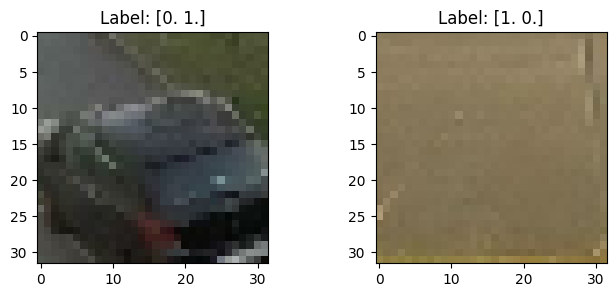

In [48]:
image_size = (32, 32) 
train_dataset_augmented = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_augment_image)
train_dataset_augmented = train_dataset_augmented.cache()
show_image_from_dataset([train_dataset_augmented])

In [49]:
num_classes = 2  
input_shape = (32, 32, 3)  

# mAlexNet (modified)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=4, strides=1, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(20, kernel_size=3, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(30, kernel_size=2, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

In [50]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

# Train the model
history = model.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)

# Save the trained model
model.save('models/malexnet_modified_augmented.keras')


Epoch 1/50
1477/1477 [==============================] - 219s 146ms/step - loss: 0.2620 - accuracy: 0.9133 - val_loss: 0.1423 - val_accuracy: 0.9534
Epoch 2/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.1498 - accuracy: 0.9464 - val_loss: 0.1560 - val_accuracy: 0.9485
Epoch 3/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.1305 - accuracy: 0.9530 - val_loss: 0.1356 - val_accuracy: 0.9526
Epoch 4/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.1183 - accuracy: 0.9578 - val_loss: 0.1199 - val_accuracy: 0.9607
Epoch 5/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.1096 - accuracy: 0.9606 - val_loss: 0.1123 - val_accuracy: 0.9602
Epoch 6/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.1007 - accuracy: 0.9636 - val_loss: 0.1170 - val_accuracy: 0.9633
Epoch 7/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.0969 - accuracy: 0.9651 - val_loss: 0.1056 - val_accur

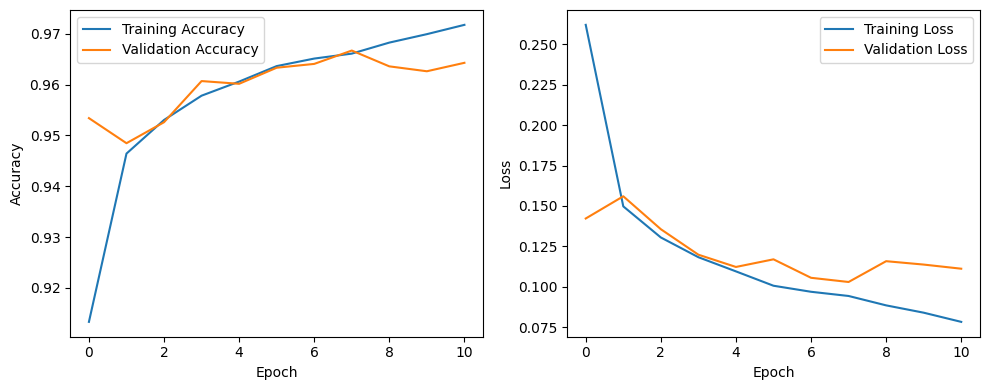

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [52]:
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")
test_accuracies.append(results[1])

498/498 [==============================] - 2s 3ms/step - loss: 0.0766 - accuracy: 0.9751
Testing on CNR_EXT dataset: test loss: 0.07663067430257797, test acc: 0.9750824570655823


## **mAlexNet (modified) + Data augmentation + Quantization**

In [53]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/malexnet_modified_augmented_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

acc = test_quantized_model('models/malexnet_modified_augmented_quantized.tflite', test_dataset)
print("mAlexNet (Modified) + Data augmentation + Quantization: test accuracy =", acc)
test_accuracies.append(acc)


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp9_suopqw\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp9_suopqw\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.9719
Batch 100 accuracy: 0.9746
Batch 150 accuracy: 0.9758
Batch 200 accuracy: 0.9742
Batch 250 accuracy: 0.9751
Batch 300 accuracy: 0.9748
Batch 350 accuracy: 0.9750
Batch 400 accuracy: 0.9750
Batch 450 accuracy: 0.9749
mAlexNet (Modified) + Data augmentation + Quantization: test accuracy = 0.9748625294579732


## **Mini DenseNet**

Train dataset size: 1477 batches
Val dataset size: 292 batches
Test dataset size: 498 batches
Image shape: (64, 32, 32, 3)


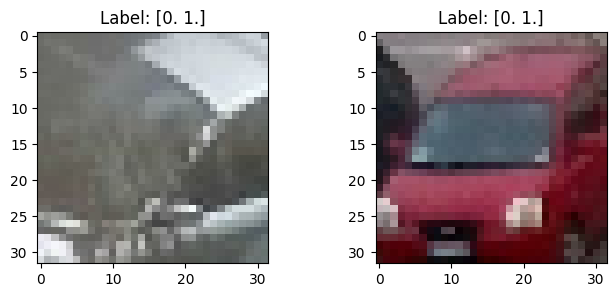

Image shape: (64, 32, 32, 3)


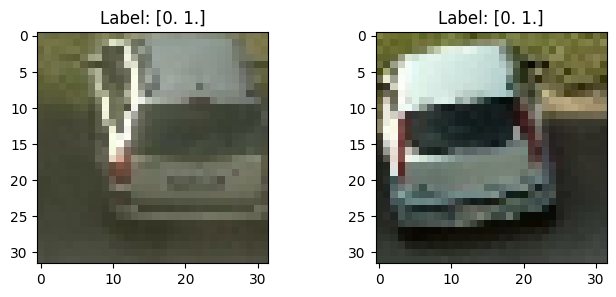

Image shape: (64, 32, 32, 3)


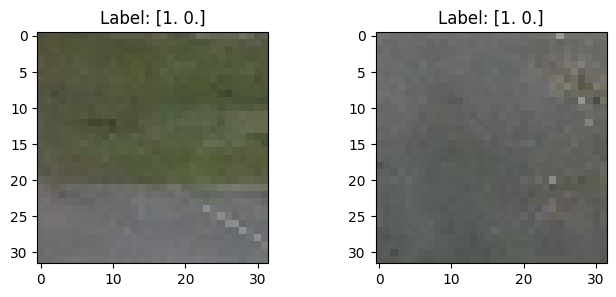

In [70]:
image_size = (32, 32)  

train_dataset = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_preprocess_image)
val_dataset = create_dataset(split_val_EXT, dataset_dir_EXT, load_and_preprocess_image)
test_dataset = create_dataset(split_test_EXT, dataset_dir_EXT, load_and_preprocess_image)

train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Train dataset size: {train_size} batches")
print(f"Val dataset size: {val_size} batches")
print(f"Test dataset size: {test_size} batches")

show_image_from_dataset([train_dataset, val_dataset, test_dataset])


In [75]:
def makemDenseNet(inputShape, modelName:str ='') -> keras.Model:
    def makeDenseBlock(groupCount: int, inputs):
        blockConcats = []
        x = tf.keras.layers.BatchNormalization()(inputs)
        x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), activation="relu", padding="same")(x)
        x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")(x)
        blockConcats.append(x)
        for count in range(groupCount):
            x = tf.keras.layers.Concatenate()(blockConcats) if len(blockConcats) > 1 else x
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), activation="relu", padding="same")(x)
            x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")(x)
            blockConcats.append(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), activation="relu", padding="same")(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        return x
    
    inputs = keras.Input(shape=inputShape, name="Input")
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(7, 7), strides=(5, 5), activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    x = makeDenseBlock(groupCount=2, inputs=x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(units=2, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name=modelName)

In [86]:
# Mini DenseNet
model = makemDenseNet(inputShape=(32, 32, 3), modelName='mDenseNet')

model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

model.summary()

Model: "mDenseNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 6, 6, 16)             2368      ['Input[0][0]']               
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 2, 2, 16)             0         ['conv2d_34[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 batch_normalization_8 (Bat  (None, 2, 2, 16)             64        ['max_pooling2d_20[0][

In [87]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

training_start_mdensenet = time.time()
history_mdensenet = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)
training_end_mdensenet = time.time()

# Save the trained model
model.save('models/mdensenet.keras')

Epoch 1/50


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1477/1477 [==============================] - 13s 8ms/step - loss: 0.1341 - accuracy: 0.9505 - val_loss: 0.1321 - val_accuracy: 0.9545
Epoch 2/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.0893 - accuracy: 0.9665 - val_loss: 0.2503 - val_accuracy: 0.9249
Epoch 3/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.0774 - accuracy: 0.9720 - val_loss: 0.1278 - val_accuracy: 0.9568
Epoch 4/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.0687 - accuracy: 0.9753 - val_loss: 0.0871 - val_accuracy: 0.9703
Epoch 5/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.0631 - accuracy: 0.9771 - val_loss: 0.1119 - val_accuracy: 0.9618
Epoch 6/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.0594 - accuracy: 0.9787 - val_loss: 0.1067 - val_accuracy: 0.9661
Epoch 7/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.0551 - accuracy: 0.9803 - val_loss: 0.1134 - val_accuracy: 0.9

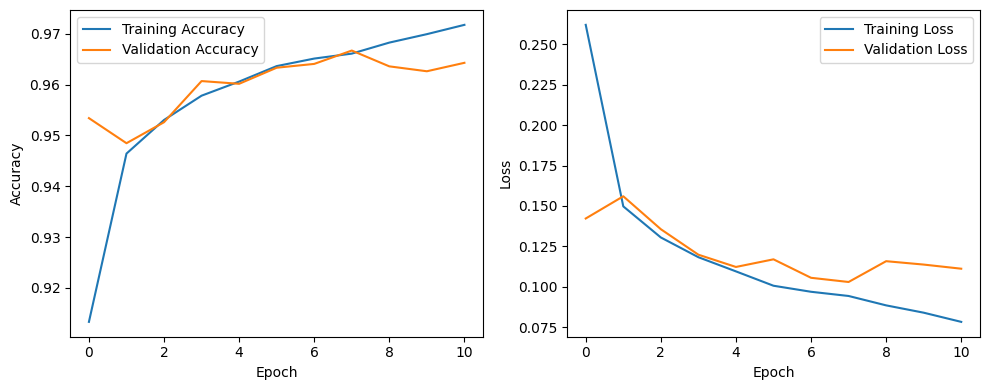

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [89]:
inference_start_mdensenet = time.time()
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_mdensenet = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

test_accuracies.append(results[1])

498/498 [==============================] - 2s 3ms/step - loss: 0.0925 - accuracy: 0.9665
Testing on CNR_EXT dataset: test loss: 0.09252789616584778, test acc: 0.9664729237556458


In [93]:
train_time = (training_end_mdensenet - training_start_mdensenet) / epoch_counter.epochs
print("mDenseNet: average training time per epoch =", train_time)
avg_train_times.append(train_time)

inference_time = inference_end_mdensenet - inference_start_mdensenet
print("mDenseNet: inference time for the whole test dataset =", inference_time)
inference_times.append(inference_time)

mDenseNet: average training time per epoch = 11.235468966620308
mDenseNet: inference time for the whole test dataset = 1.86934232711792


## **Mini DenseNet + Quantization**

In [94]:
# def representative_data_gen():
#   for input_value, labels in train_dataset.take(2):
#     yield [input_value]

# # Quantize the model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_data_gen
# quantized_model = converter.convert()

# with open('models/mdensenet_quantized.tflite', 'wb') as f:
#     f.write(quantized_model)

# acc = test_quantized_model('models/mdensenet_quantized.tflite', test_dataset)
# print("mDenseNet + Quantization: test accuracy =", acc)
# test_accuracies.append(acc)

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmptor9mbhb\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmptor9mbhb\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.4308
Batch 100 accuracy: 0.4258
Batch 150 accuracy: 0.4207


KeyboardInterrupt: 

In [96]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/mdensenet_quantized.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmphzg2orct\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmphzg2orct\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [101]:
interpreter = tf.lite.Interpreter(model_path='models/mdensenet_quantized.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmin(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)

test_accuracies.append(accuracy)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[1. 0.]
[1]
0
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[1. 0.]
[1]
0
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[1. 0.]
[1]
0
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]]
[1. 0.]
[1]
0
[[0.90234375 0.08984375]]
[0. 1.]
[1]
1
here
[[0.90234375 0.08984375]

## **Mini DenseNet + Data augmentation**

Image shape: (64, 32, 32, 3)


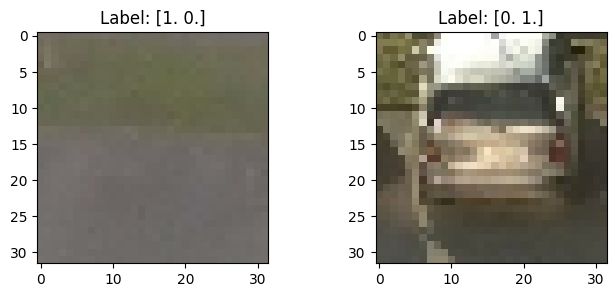

In [102]:
image_size = (32, 32) 
train_dataset_augmented = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_augment_image)
train_dataset_augmented = train_dataset_augmented.cache()
show_image_from_dataset([train_dataset_augmented])

In [103]:
model = makemDenseNet(inputShape=(32, 32, 3), modelName='mDenseNet')

opt = tf.optimizers.Adam()
model.compile(
    optimizer = opt,
    loss = keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [104]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

# Train the model
history = model.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)

# Save the trained model
model.save('models/mdensenet_augmented.keras')

Epoch 1/50


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1477/1477 [==============================] - 194s 129ms/step - loss: 0.2032 - accuracy: 0.9247 - val_loss: 0.2999 - val_accuracy: 0.8548
Epoch 2/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.1607 - accuracy: 0.9392 - val_loss: 0.1985 - val_accuracy: 0.9234
Epoch 3/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.1462 - accuracy: 0.9449 - val_loss: 0.3797 - val_accuracy: 0.8242
Epoch 4/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.1381 - accuracy: 0.9484 - val_loss: 0.2867 - val_accuracy: 0.8579
Epoch 5/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.1307 - accuracy: 0.9509 - val_loss: 0.1196 - val_accuracy: 0.9568
Epoch 6/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.1271 - accuracy: 0.9526 - val_loss: 0.1398 - val_accuracy: 0.9514
Epoch 7/50
1477/1477 [==============================] - 10s 7ms/step - loss: 0.1190 - accuracy: 0.9556 - val_loss: 0.1137 - val_accuracy: 

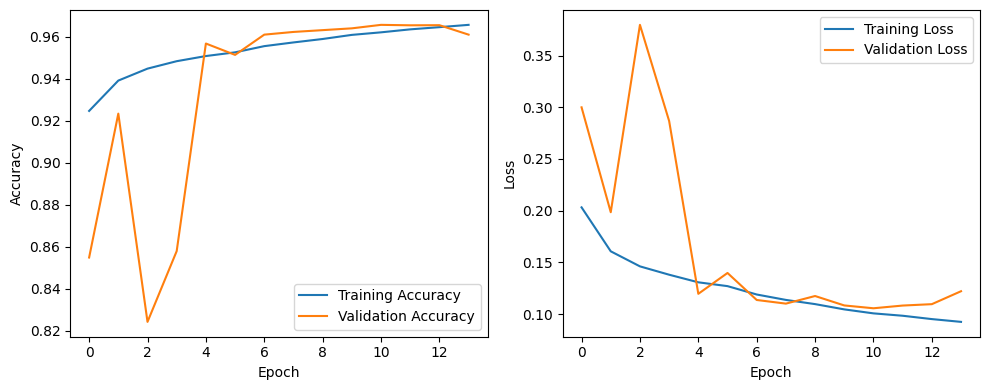

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [106]:
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")
test_accuracies.append(results[1])

498/498 [==============================] - 2s 4ms/step - loss: 0.1040 - accuracy: 0.9619
Testing on CNR_EXT dataset: test loss: 0.10396814346313477, test acc: 0.9619167447090149


## **Mini DenseNet + Data augmentation + Quantization**

In [107]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/mdensenet_augmented_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

acc = test_quantized_model('models/mdensenet_augmented_quantized.tflite', test_dataset)
print("mDenseNet + Data augmentation + Quantization: test accuracy =", acc)
test_accuracies.append(acc)


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp6s0x7r8q\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp6s0x7r8q\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.9493
Batch 100 accuracy: 0.9538
Batch 150 accuracy: 0.9535
Batch 200 accuracy: 0.9529
Batch 250 accuracy: 0.9530
Batch 300 accuracy: 0.9527
Batch 350 accuracy: 0.9517
Batch 400 accuracy: 0.9521
Batch 450 accuracy: 0.9514
mDenseNet + Data augmentation + Quantization: test accuracy = 0.9508562450903378


## **Proposed Model**

Train dataset size: 1477 batches
Val dataset size: 292 batches
Test dataset size: 498 batches
Image shape: (64, 32, 32, 3)


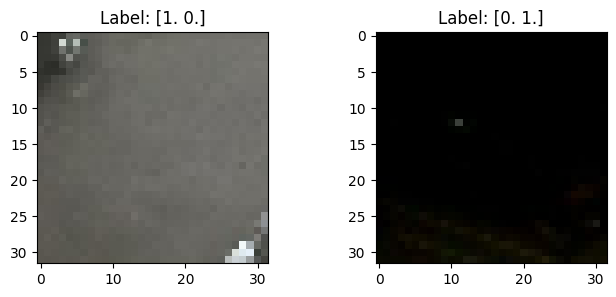

Image shape: (64, 32, 32, 3)


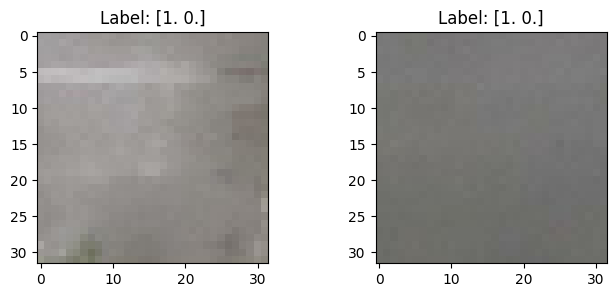

Image shape: (64, 32, 32, 3)


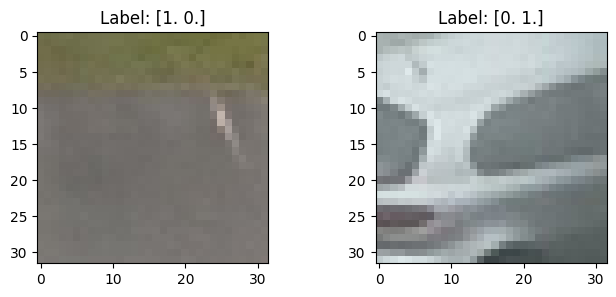

In [19]:
image_size = (32, 32)  

train_dataset = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_preprocess_image)
val_dataset = create_dataset(split_val_EXT, dataset_dir_EXT, load_and_preprocess_image)
test_dataset = create_dataset(split_test_EXT, dataset_dir_EXT, load_and_preprocess_image)

train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Train dataset size: {train_size} batches")
print(f"Val dataset size: {val_size} batches")
print(f"Test dataset size: {test_size} batches")

show_image_from_dataset([train_dataset, val_dataset, test_dataset])


In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [14]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 6, 6, 64)         

In [15]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

training_start_proposed = time.time()
history_proposed = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)
training_end_proposed = time.time()

# Save the trained model
model.save('models/proposed.keras')

Epoch 1/50




1477/1477 [==============================] - 32s 21ms/step - loss: 0.2504 - accuracy: 0.9298 - val_loss: 0.0928 - val_accuracy: 0.9711
Epoch 2/50
1477/1477 [==============================] - 25s 17ms/step - loss: 0.1153 - accuracy: 0.9616 - val_loss: 0.0919 - val_accuracy: 0.9698
Epoch 3/50
1477/1477 [==============================] - 25s 17ms/step - loss: 0.0998 - accuracy: 0.9671 - val_loss: 0.0747 - val_accuracy: 0.9774
Epoch 4/50
1477/1477 [==============================] - 25s 17ms/step - loss: 0.0912 - accuracy: 0.9702 - val_loss: 0.0747 - val_accuracy: 0.9752
Epoch 5/50
1477/1477 [==============================] - 25s 17ms/step - loss: 0.0841 - accuracy: 0.9727 - val_loss: 0.0680 - val_accuracy: 0.9805
Epoch 6/50
1477/1477 [==============================] - 25s 17ms/step - loss: 0.0797 - accuracy: 0.9738 - val_loss: 0.0717 - val_accuracy: 0.9777
Epoch 7/50
1477/1477 [==============================] - 25s 17ms/step - loss: 0.0766 - accuracy: 0.9749 - val_loss: 0.0635 - val_accu

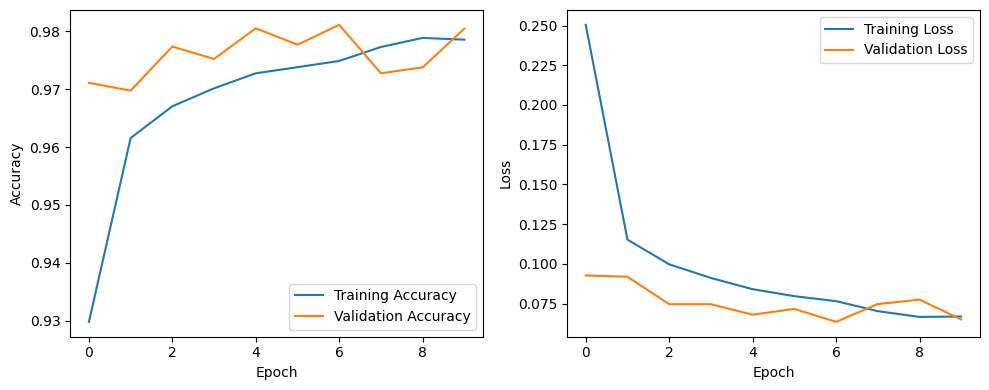

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history_proposed.history['accuracy'], label='Training Accuracy')
ax1.plot(history_proposed.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_proposed.history['loss'], label='Training Loss')
ax2.plot(history_proposed.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
inference_start_proposed = time.time()
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_proposed = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

test_accuracies.append(results[1])

498/498 [==============================] - 5s 9ms/step - loss: 0.0496 - accuracy: 0.9857
Testing on CNR_EXT dataset: test loss: 0.049641285091638565, test acc: 0.9856716394424438


In [18]:
train_time = (training_end_proposed - training_start_proposed) / epoch_counter.epochs
print("Proposed model: average training time per epoch =", train_time)
avg_train_times.append(train_time)

inference_time = inference_end_proposed - inference_start_proposed
print("Proposed model: inference time for the whole test dataset =", inference_time)
inference_times.append(inference_time)

Proposed model: average training time per epoch = 25.579031014442442
Proposed model: inference time for the whole test dataset = 4.643537998199463


In [19]:
avg_train_times.append(25.58)
inference_times.append(4.64)
test_accuracies.append(98.57)

## **Proposed model + Quantization**

In [21]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/proposed_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

acc = test_quantized_model('models/proposed_quantized.tflite', test_dataset)
print("Proposed model + Quantization: test accuracy =", acc)
test_accuracies.append(acc)

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp1j068ct3\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp1j068ct3\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.9837
Batch 100 accuracy: 0.9863
Batch 150 accuracy: 0.9857
Batch 200 accuracy: 0.9857
Batch 250 accuracy: 0.9861
Batch 300 accuracy: 0.9859
Batch 350 accuracy: 0.9858
Batch 400 accuracy: 0.9859
Batch 450 accuracy: 0.9859
Proposed model + Quantization: test accuracy = 0.9856402199528672


## **Proposed model + Data augmentation**

Image shape: (64, 32, 32, 3)


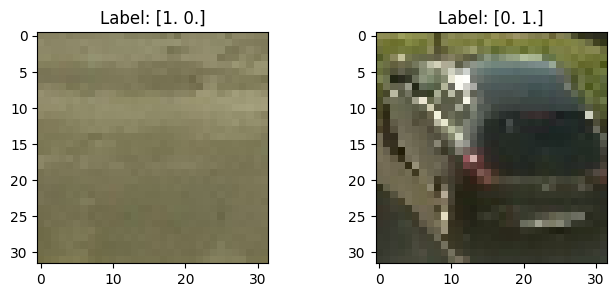

In [22]:
image_size = (32, 32) 
train_dataset_augmented = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_augment_image)
train_dataset_augmented = train_dataset_augmented.cache()
show_image_from_dataset([train_dataset_augmented])

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [24]:
opt = tf.optimizers.Adam()
model.compile(
    optimizer = opt,
    loss = keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [25]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

# Train the model
history = model.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)

# Save the trained model
model.save('models/proposed_augmented.keras')

Epoch 1/50


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1477/1477 [==============================] - 154s 102ms/step - loss: 0.2525 - accuracy: 0.9126 - val_loss: 0.1599 - val_accuracy: 0.9396
Epoch 2/50
1477/1477 [==============================] - 21s 14ms/step - loss: 0.1545 - accuracy: 0.9441 - val_loss: 0.2193 - val_accuracy: 0.9142
Epoch 3/50
1477/1477 [==============================] - 21s 14ms/step - loss: 0.1331 - accuracy: 0.9532 - val_loss: 0.1277 - val_accuracy: 0.9542
Epoch 4/50
1477/1477 [==============================] - 21s 14ms/step - loss: 0.1204 - accuracy: 0.9576 - val_loss: 0.1325 - val_accuracy: 0.9504
Epoch 5/50
1477/1477 [==============================] - 21s 14ms/step - loss: 0.1156 - accuracy: 0.9596 - val_loss: 0.1349 - val_accuracy: 0.9477
Epoch 6/50
1477/1477 [==============================] - 20s 14ms/step - loss: 0.1088 - accuracy: 0.9615 - val_loss: 0.1237 - val_accuracy: 0.9538
Trained for 6 epochs


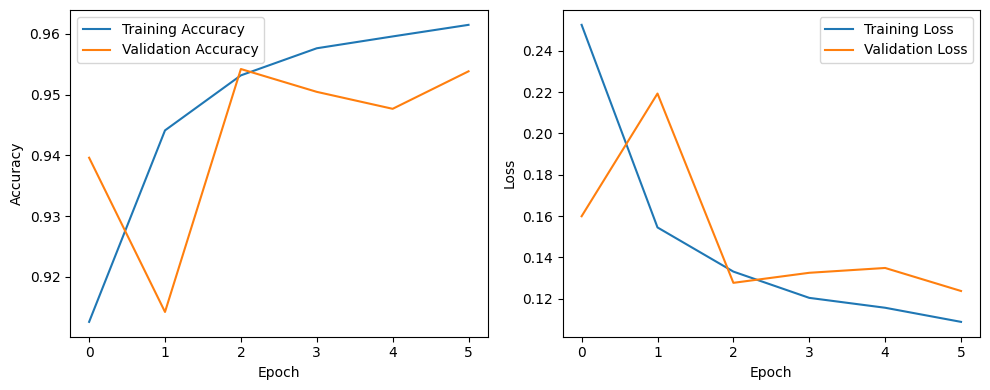

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [27]:
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")
test_accuracies.append(results[1])

498/498 [==============================] - 3s 5ms/step - loss: 0.1033 - accuracy: 0.9654
Testing on CNR_EXT dataset: test loss: 0.10327758640050888, test acc: 0.9654045701026917


## **Proposed model + Data augmentation + Quantization**

In [28]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/proposed_augmented_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

acc = test_quantized_model('models/proposed_augmented_quantized.tflite', test_dataset)
print("Proposed model + Data augmentation + Quantization: test accuracy =", acc)
test_accuracies.append(acc)


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpw5b7_o37\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpw5b7_o37\assets
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Batch 50 accuracy: 0.9592
Batch 100 accuracy: 0.9607
Batch 150 accuracy: 0.9618
Batch 200 accuracy: 0.9620
Batch 250 accuracy: 0.9627
Batch 300 accuracy: 0.9632
Batch 350 accuracy: 0.9625
Batch 400 accuracy: 0.9630
Batch 450 accuracy: 0.9636
Proposed model + Data augmentation + Quantization: test accuracy = 0.9634564021995287


In [22]:

test_accuracies.append(96.34)

## **Squeeze Net**

In [287]:
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import regularizers

In [288]:
def fire_module(input_fire, s1, e1, e3, weight_decay_l2, fireID):  
    '''
    A wrapper to build fire module
    
    # Arguments
        input_fire: input activations
        s1: number of filters for squeeze step
        e1: number of filters for 1x1 expansion step
        e3: number of filters for 3x3 expansion step
        weight_decay_l2: weight decay for conv layers
        fireID: ID for the module
    
    # Return
        Output activations
    '''
    
    # Squezee step
    output_squeeze = Convolution2D(
        s1, (1, 1), activation='relu', 
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_squeeze',
        data_format="channels_last")(input_fire)
    # Expansion steps
    output_expand1 = Convolution2D(
        e1, (1, 1), activation='relu', 
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_expand1',
        data_format="channels_last")(output_squeeze)
    output_expand2 = Convolution2D(
        e3, (3, 3), activation='relu',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_expand2',
        data_format="channels_last")(output_squeeze)
    # Merge expanded activations
    output_fire = Concatenate(axis=3)([output_expand1, output_expand2])
    return output_fire

def SqueezeNet(num_classes, weight_decay_l2=0.0001, inputs=(128, 128, 3)):
    '''
    A wrapper to build SqueezeNet Model
    
    # Arguments
        num_classes: number of classes defined for classification task
        weight_decay_l2: weight decay for conv layers
        inputs: input image dimensions
    
    # Return
        A SqueezeNet Keras Model
    '''
    input_img = Input(shape=inputs)
    
    conv1 = Convolution2D(
        32, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1',
        data_format="channels_last")(input_img)
    
    maxpool1 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool1',
        data_format="channels_last")(conv1)
    
    fire2 = fire_module(maxpool1, 8, 16, 16, weight_decay_l2, 2)    
    fire3 = fire_module(fire2, 8, 16, 16, weight_decay_l2, 3)
    fire4 = fire_module(fire3, 16, 32, 32, weight_decay_l2, 4)
    
    maxpool4 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool4',
        data_format="channels_last")(fire4)
    
    fire5 = fire_module(maxpool4, 16, 32, 32, weight_decay_l2, 5)
    fire6 = fire_module(fire5, 32, 64, 64, weight_decay_l2, 6)
    fire7 = fire_module(fire6, 32, 64, 64, weight_decay_l2, 7)
    fire8 = fire_module(fire7, 64, 128, 128, weight_decay_l2, 8)
    
    maxpool8 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool8',
        data_format="channels_last")(fire8)
    
    fire9 = fire_module(maxpool8, 64, 128, 128, weight_decay_l2, 9)
    fire9_dropout = Dropout(0.5, name='fire9_dropout')(fire9)
    
    conv10 = Convolution2D(
        num_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10',
        data_format="channels_last")(fire9_dropout)

    global_avgpool10 = GlobalAveragePooling2D(data_format='channels_last')(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)
    
    return Model(inputs=input_img, outputs=softmax)

In [304]:
squeezeNet = SqueezeNet(num_classes=2, inputs=(32, 32, 3))

squeezeNet.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

squeezeNet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 32)           4736      ['input_5[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 8, 8, 32)             0         ['conv1[0][0]']               
                                                                                                  
 fire2_squeeze (Conv2D)      (None, 8, 8, 8)              264       ['maxpool1[0][0]']            
                                                                                            

### Regular Training

In [305]:
training_start_squeezenet = time.time()
# Train the model
history_squeezenet = squeezeNet.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_squeezenet = time.time()

# Save the trained model
model.save('models/squeezenet_standard.h5')

Epoch 1/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.4425 - accuracy: 0.9612 - val_loss: 0.4184 - val_accuracy: 0.9754
Epoch 2/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.4050 - accuracy: 0.9781 - val_loss: 0.4126 - val_accuracy: 0.9691
Epoch 3/50
1477/1477 [==============================] - 35s 24ms/step - loss: 0.3943 - accuracy: 0.9815 - val_loss: 0.4069 - val_accuracy: 0.9751
Epoch 4/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.3895 - accuracy: 0.9824 - val_loss: 0.3960 - val_accuracy: 0.9812
Epoch 5/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.3846 - accuracy: 0.9846 - val_loss: 0.3969 - val_accuracy: 0.9811
Epoch 6/50
1477/1477 [==============================] - 33s 22ms/step - loss: 0.3818 - accuracy: 0.9859 - val_loss: 0.4006 - val_accuracy: 0.9776
Epoch 7/50
1477/1477 [==============================] - 35s 23ms/step - loss: 0.3793 - accuracy: 0.9871 - val_loss: 0.3946 -

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


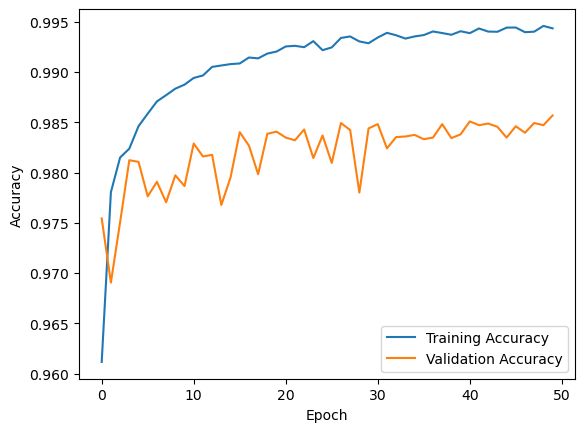

In [307]:
# Plot training and validation loss over epochs
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

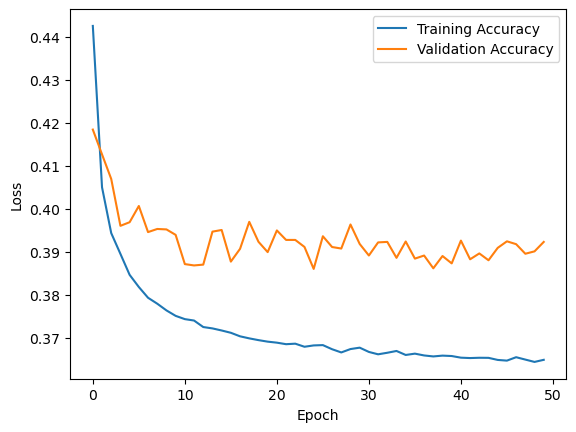

In [308]:
plt.plot(history_squeezenet.history['loss'], label='Training Accuracy')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [309]:
inference_start_squeezenet = time.time()
results = squeezeNet.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_squeezenet = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 4s 8ms/step - loss: 0.3818 - accuracy: 0.9857
Testing on CNR_EXT dataset: test loss: 0.38176557421684265, test acc: 0.9857030510902405


### Quantization

In [310]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(squeezeNet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/squeezenet_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp0rzikb2r/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp0rzikb2r/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-17 15:22:45.416061: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-17 15:22:45.416200: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-17 15:22:45.416731: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp0rzikb2r
2023-11-17 15:22:45.420691: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-17 15:22:45.420700: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [312]:
interpreter = tf.lite.Interpreter(model_path='models/squeezenet_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.01171875 0.98828125]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.

### Data augmentation

In [318]:
training_start_squeezenet_aug = time.time()
# Train the model
history_squeezenet_aug = squeezeNet.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_squeezenet_aug = time.time()

# Save the trained model
model.save('models/squeezenet_augmented.h5')

Epoch 1/50
1477/1477 [==============================] - 63s 42ms/step - loss: 0.4007 - accuracy: 0.9688 - val_loss: 0.3851 - val_accuracy: 0.9786
Epoch 2/50
1477/1477 [==============================] - 60s 40ms/step - loss: 0.3938 - accuracy: 0.9736 - val_loss: 0.3857 - val_accuracy: 0.9798
Epoch 3/50
1477/1477 [==============================] - 59s 39ms/step - loss: 0.3916 - accuracy: 0.9756 - val_loss: 0.3859 - val_accuracy: 0.9793
Epoch 4/50
1477/1477 [==============================] - 58s 39ms/step - loss: 0.3903 - accuracy: 0.9760 - val_loss: 0.3838 - val_accuracy: 0.9822
Epoch 5/50
1477/1477 [==============================] - 57s 38ms/step - loss: 0.3882 - accuracy: 0.9771 - val_loss: 0.3831 - val_accuracy: 0.9839
Epoch 6/50
1477/1477 [==============================] - 57s 38ms/step - loss: 0.3890 - accuracy: 0.9769 - val_loss: 0.3828 - val_accuracy: 0.9812
Epoch 7/50
1477/1477 [==============================] - 58s 39ms/step - loss: 0.3875 - accuracy: 0.9788 - val_loss: 0.3802 -

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


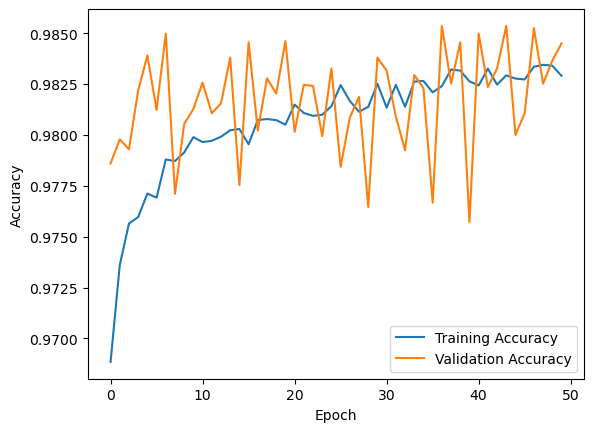

In [319]:
# Plot training and validation loss over epochs
plt.plot(history_squeezenet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_squeezenet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

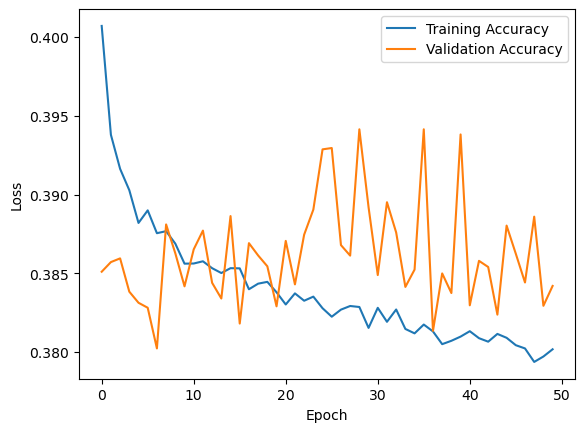

In [320]:
# Plot training and validation loss over epochs
plt.plot(history_squeezenet_aug.history['loss'], label='Training Accuracy')
plt.plot(history_squeezenet_aug.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [321]:
inference_start_squeezenet_aug = time.time()
results = squeezeNet.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_squeezenet_aug = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 4s 8ms/step - loss: 0.3765 - accuracy: 0.9866
Testing on CNR_EXT dataset: test loss: 0.37649935483932495, test acc: 0.9866142868995667


### Data augmentation + Quantization

In [322]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(squeezeNet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/squeezenet_augmented_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpv87_nctd/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpv87_nctd/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-17 16:20:02.292221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-17 16:20:02.292378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-17 16:20:02.293999: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpv87_nctd
2023-11-17 16:20:02.298184: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-17 16:20:02.298191: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [323]:
interpreter = tf.lite.Interpreter(model_path='models/squeezenet_augmented_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.00390625 0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.9921875 0.0078125]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.  

## **MobileNet**

In [ ]:
image_size = (32, 32)  

train_dataset = create_dataset(split_train_EXT, dataset_dir_EXT, load_and_preprocess_image)
val_dataset = create_dataset(split_val_EXT, dataset_dir_EXT, load_and_preprocess_image)
test_dataset = create_dataset(split_test_EXT, dataset_dir_EXT, load_and_preprocess_image)

show_image_from_dataset([train_dataset, val_dataset, test_dataset])


In [ ]:
from tensorflow.keras.applications import MobileNetV2

input_shape = (32, 32, 3)

model = MobileNetV2(weights=None, input_shape=input_shape)
last_layer = model.layers[-1]
model.layers.pop()
new_last_layer = Dense(2, activation='sigmoid')(last_layer.output)
model.add(new_last_layer)
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

In [ ]:
epochs = 50
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max", patience=3,
                                        restore_best_weights=True)
epoch_counter = epoch_counter_callback()

training_start_mobilenet = time.time()
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[earlystopping, epoch_counter]
)
training_end_mobilenet = time.time()

# Save the trained model
model.save('models/mobilenet.keras')

## **MobileNet + Quantization**

## **MobileNet + Data augmentation**

## **MobileNet + Data augmentation + Quantization**

## **Visual Representation**

/var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/ipykernel_80594/1537107606.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(models, rotation=45, ha='right')
/var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/ipykernel_80594/1537107606.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(models, rotation=45, ha='right')


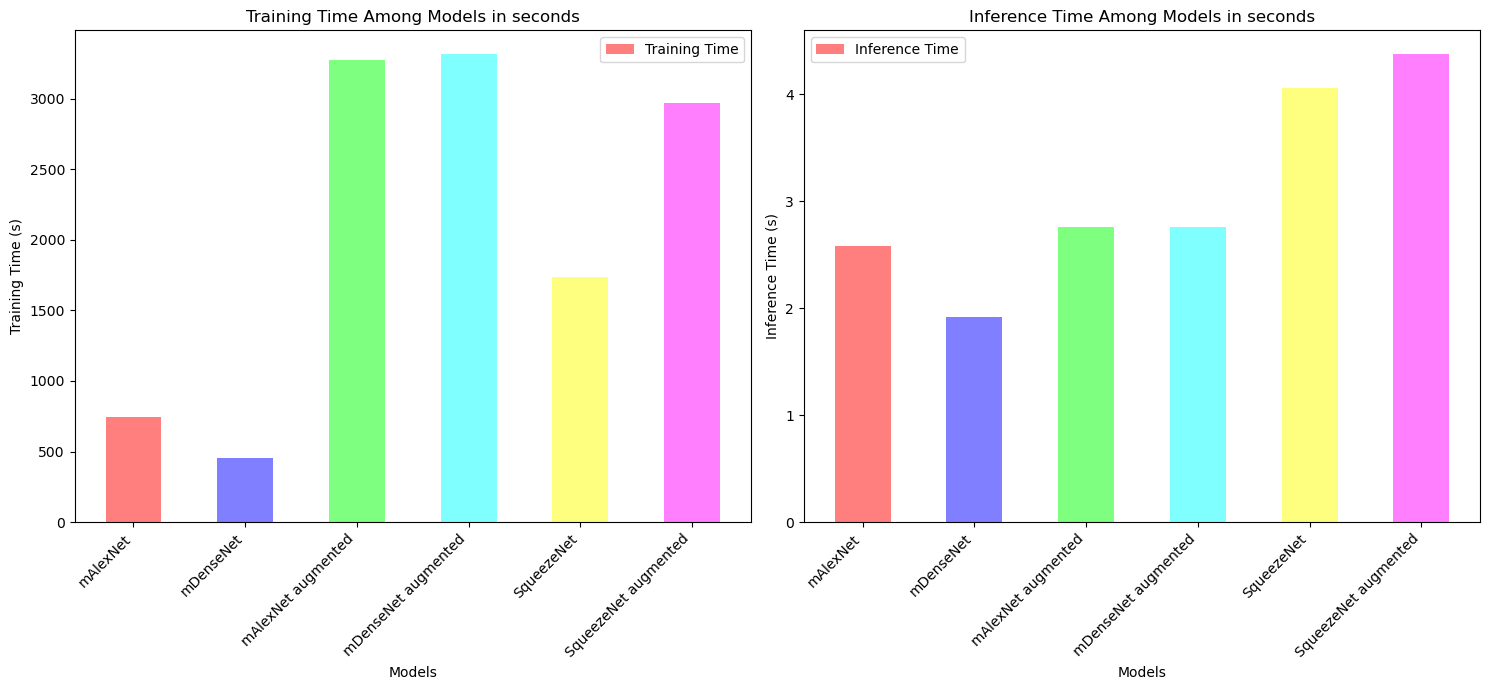

In [42]:
# Visualisation
models = ["mAlexNet", "mDenseNet", "mAlexNet augmented", "mDenseNet augmented", "SqueezeNet", "SqueezeNet augmented"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.bar(models, [training_time_malexnet, training_time_mdensenet, training_time_malexnet_aug, training_time_mdensenet_aug, training_time_squeezenet, training_time_squeezenet_aug], width=0.5, color=[(1, 0, 0, 0.5), (0, 0, 1, 0.5), (0, 1, 0, 0.5), (0, 1, 1, 0.5), (1, 1, 0, 0.5), (1, 0, 1, 0.5)], label='Training Time')
ax1.set_xlabel('Models')
ax1.set_ylabel('Training Time (s)')
ax1.set_title('Training Time Among Models in seconds')
ax1.legend()
ax1.set_xticklabels(models, rotation=45, ha='right')

ax2.bar(models, [inference_time_malexnet, inference_time_mdensenet, inference_time_malexnet_aug, inference_time_malexnet_aug, inference_time_squeezenet, inference_time_squeezenet_aug], width=0.5, color=[(1, 0, 0, 0.5), (0, 0, 1, 0.5), (0, 1, 0, 0.5), (0, 1, 1, 0.5), (1, 1, 0, 0.5), (1, 0, 1, 0.5)], label='Inference Time')
ax2.set_xlabel('Models')
ax2.set_ylabel('Inference Time (s)')
ax2.set_title('Inference Time Among Models in seconds')
ax2.legend()
ax2.set_xticklabels(models, rotation=45, ha='right') 

plt.tight_layout()
plt.show()

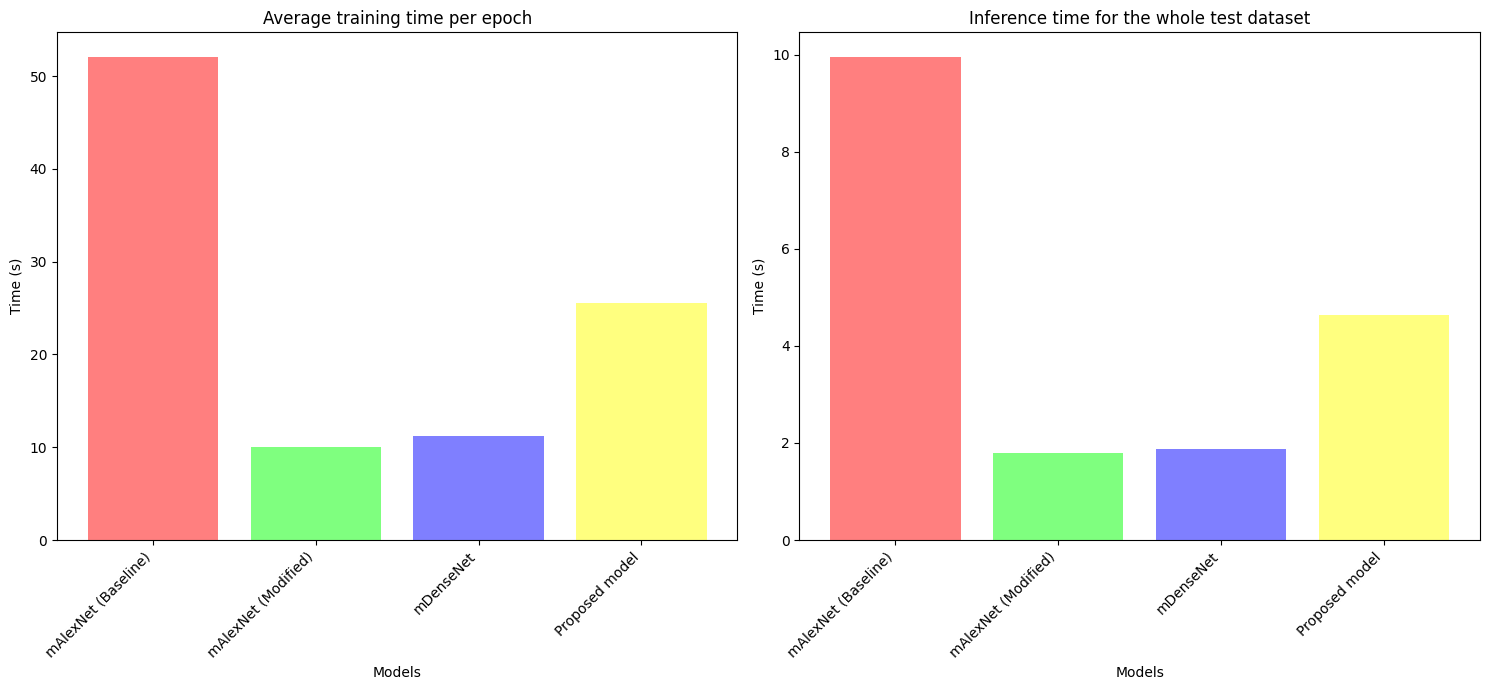

In [42]:
models = ['mAlexNet (Baseline)', 'mAlexNet (Modified)', 'mDenseNet', 'Proposed model']

colors = [
    (1, 0, 0, 0.5),    # Red
    (0, 1, 0, 0.5),    # Green
    (0, 0, 1, 0.5),    # Blue
    (1, 1, 0, 0.5),    # Yellow
    (1, 0, 1, 0.5),    # Magenta
    (0, 1, 1, 0.5),    # Cyan
    (0.5, 0.5, 0.5, 0.5),  # Gray
    (1, 0.5, 0, 0.5),  # Orange
    (0.5, 0, 1, 0.5),  # Purple
    (0, 0.5, 0.5, 0.5),  # Teal
    (0.5, 1, 0, 0.5),  # Lime
    (0.5, 0, 0, 0.5),  # Maroon
    (0, 0.5, 0, 0.5),  # Olive
    (0, 0, 0.5, 0.5),  # Navy
    (0.5, 0.5, 1, 0.5),  # Light Blue
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.bar(models, avg_train_times, color=colors[:4])
ax1.set_xlabel('Models')
ax1.set_ylabel('Time (s)')
ax1.set_title('Average training time per epoch')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')

ax2.bar(models, inference_times, color=colors[:4])
ax2.set_xlabel('Models')
ax2.set_ylabel('Time (s)')
ax2.set_title('Inference time for the whole test dataset')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right') 

plt.tight_layout()
plt.show()

In [29]:
x = test_accuracies.copy()
print(x[9])
x.pop(9)
print(x[9])
print(len(test_accuracies))

96.2
95.08
15


15


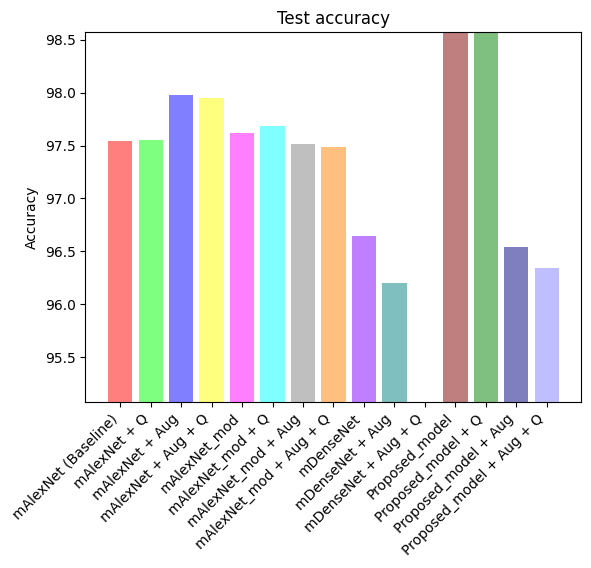

[97.54, 97.55, 97.98, 97.95, 97.62, 97.68, 97.51, 97.49, 96.65, 96.2, 95.08, 98.57, 98.56, 96.54, 96.34]


In [40]:
models = ['mAlexNet (Baseline)', 'mAlexNet + Q', 'mAlexNet + Aug', 'mAlexNet + Aug + Q',
          'mAlexNet_mod', 'mAlexNet_mod + Q', 'mAlexNet_mod + Aug', 'mAlexNet_mod + Aug + Q',
         'mDenseNet',  'mDenseNet + Aug', 'mDenseNet + Aug + Q', 
         'Proposed_model', 'Proposed_model + Q', 'Proposed_model + Aug', 'Proposed_model + Aug + Q',]

print(len(models))

fig, ax = plt.subplots()
ax.bar(models, test_accuracies, color=colors)
ax.set_ylim(min(x) - 0.0005, max(x) + 0.0005)
ax.set_ylabel('Accuracy')
ax.set_title('Test accuracy')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha='right')
plt.show()
print(test_accuracies)